In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


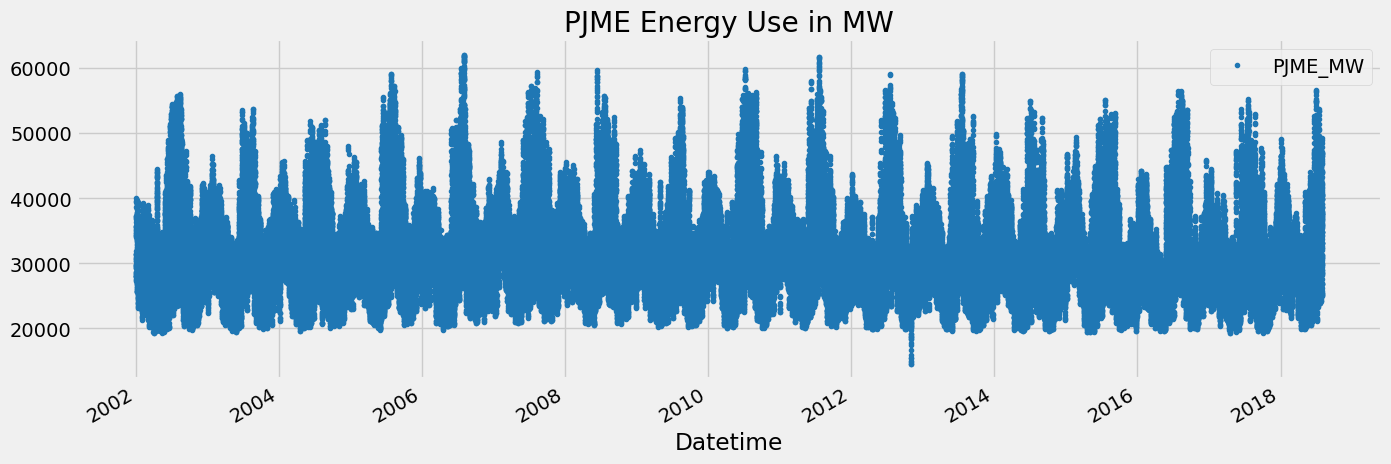

In [4]:
df.plot(style='.', figsize=(15, 5), 
        color = color_pal[0], 
        title = 'PJME Energy Use in MW')
plt.show()

## Train Test Split

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

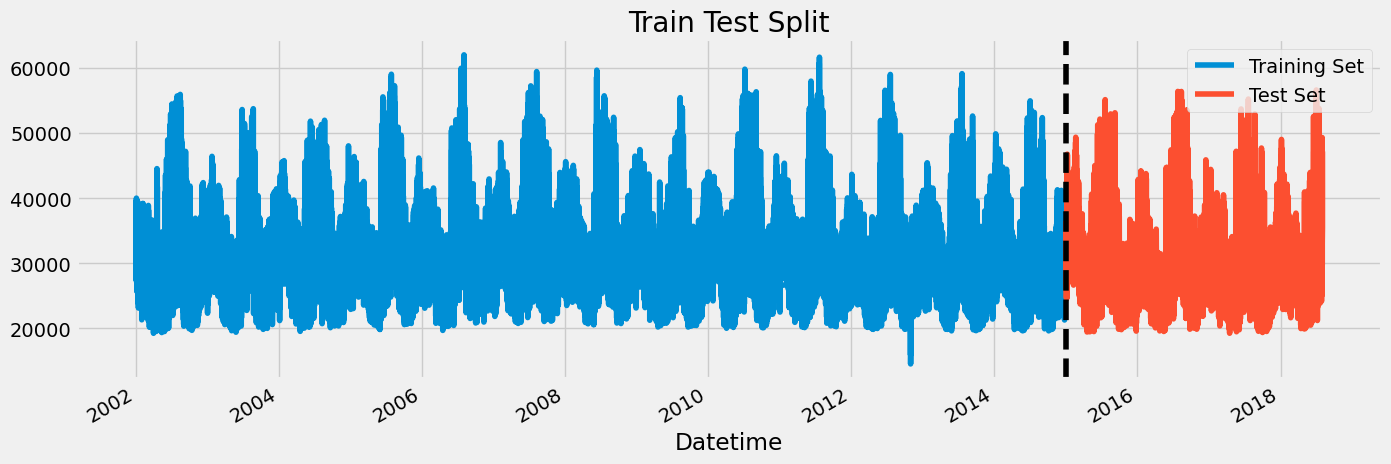

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, label = 'Training Set')
test.plot(ax=ax, label = 'Test Set')

ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Train Test Split')

plt.show()

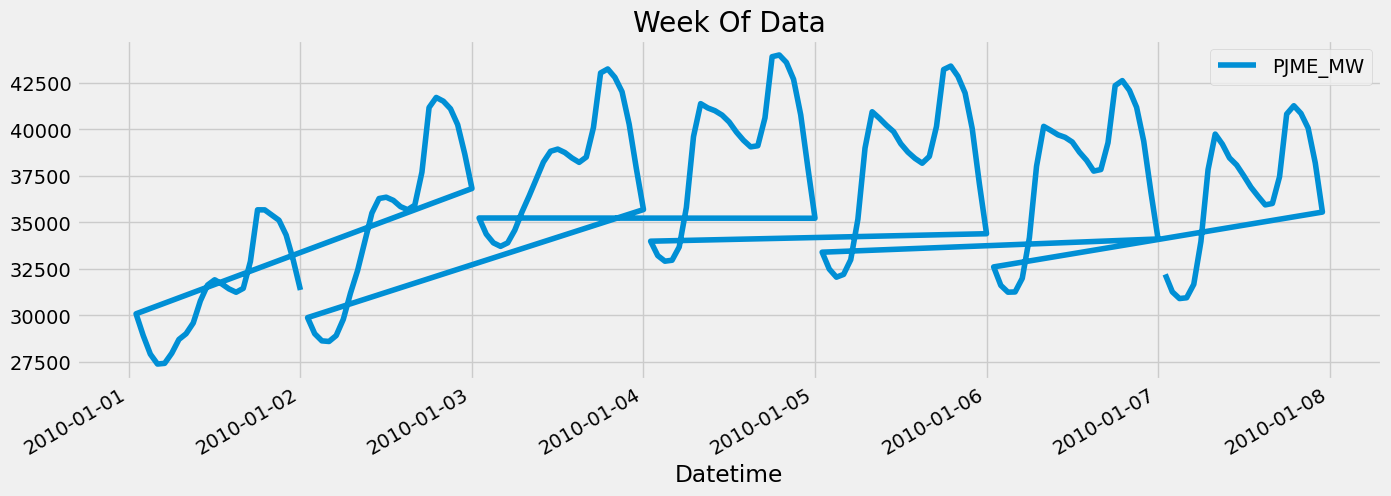

In [7]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## Feature Creation

In [8]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    
    return df

In [9]:
df = create_features(df)

## Visualise Feature / Target Relationship

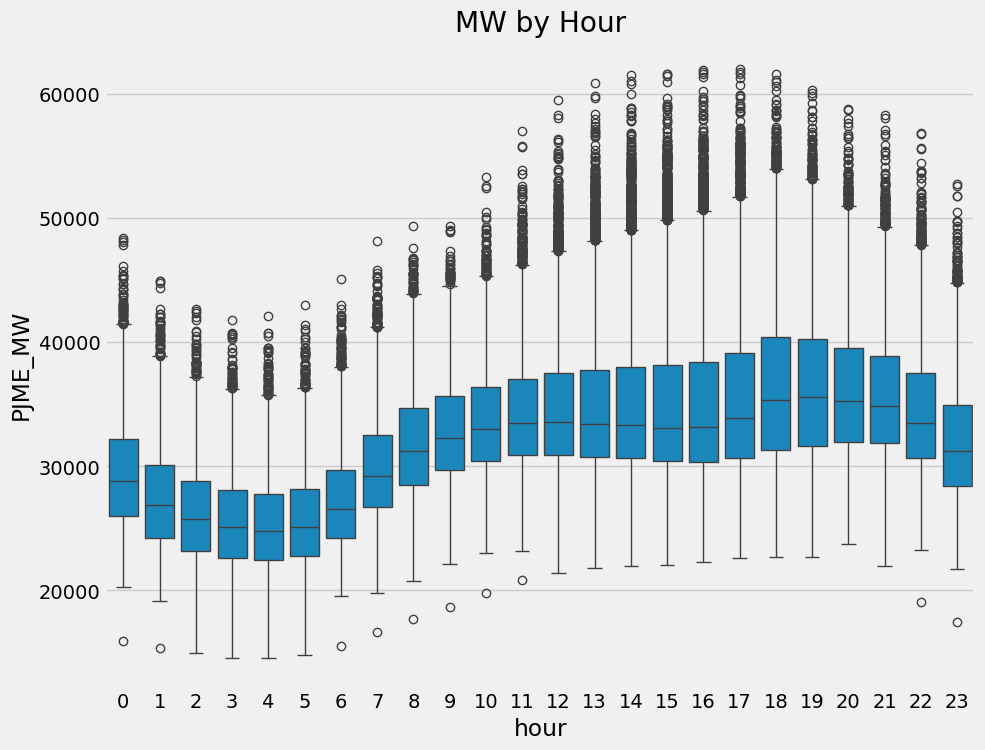

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')

plt.show()

C:\Users\khais\AppData\Local\Temp\ipykernel_42052\2257751490.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


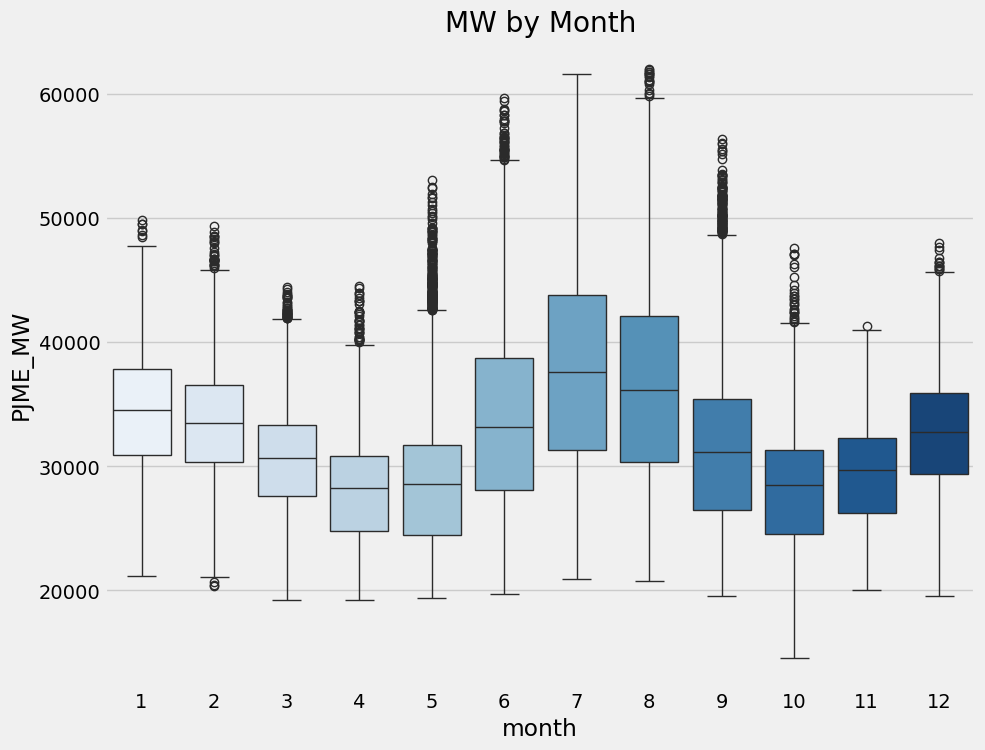

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')

plt.show()

## Modelling

In [12]:
train = create_features(train)
test = create_features(test)

C:\Users\khais\AppData\Local\Temp\ipykernel_42052\3563375303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
C:\Users\khais\AppData\Local\Temp\ipykernel_42052\3563375303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.day_of_week
C:\Users\khais\AppData\Local\Temp\ipykernel_42052\3563375303.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [13]:
features = [col for col in df.columns if col != 'PJME_MW']
target = 'PJME_MW'

In [14]:
X_train = train[features]
X_test = test[features]

y_train = train[target]
y_test = test[target]

In [15]:
regressor = xgb.XGBRegressor(n_estimators = 1000, 
                             early_stopping_rounds = 50, 
                             learning_rate = 0.01)

regressor.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose = 100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

In [16]:
fi = pd.DataFrame(data = regressor.feature_importances_, 
                  index = features, columns = ['importance'])\
                  .sort_values('importance',ascending=False)\
#                   .transpose()

In [17]:
fi

,importance
hour,0.463878
month,0.203161
dayofweek,0.162005
dayofyear,0.118251
quarter,0.028881
year,0.023824


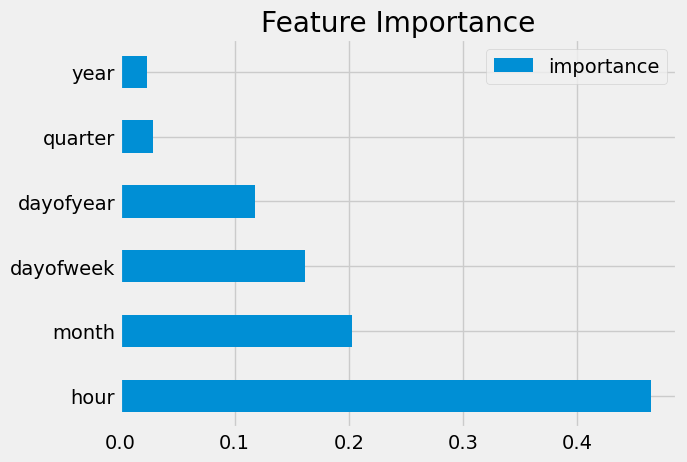

In [18]:
fi.plot(kind='barh', title = 'Feature Importance')
plt.show()

## Prediction

In [19]:
test['prediction'] = regressor.predict(X_test)
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

C:\Users\khais\AppData\Local\Temp\ipykernel_42052\942291257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = regressor.predict(X_test)


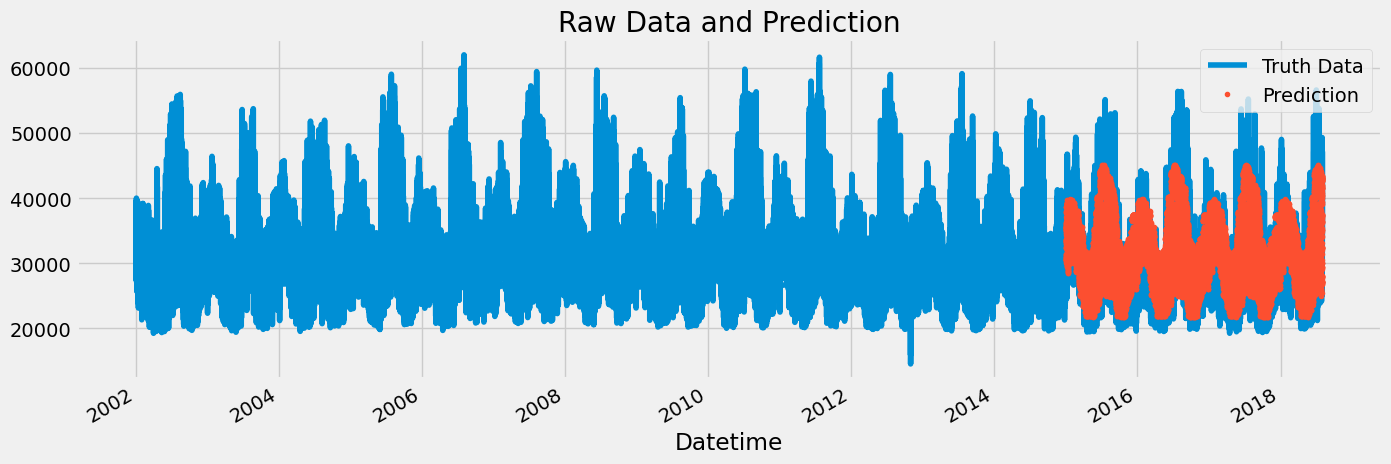

In [20]:
ax = df[['PJME_MW']].plot(figsize = (15, 5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

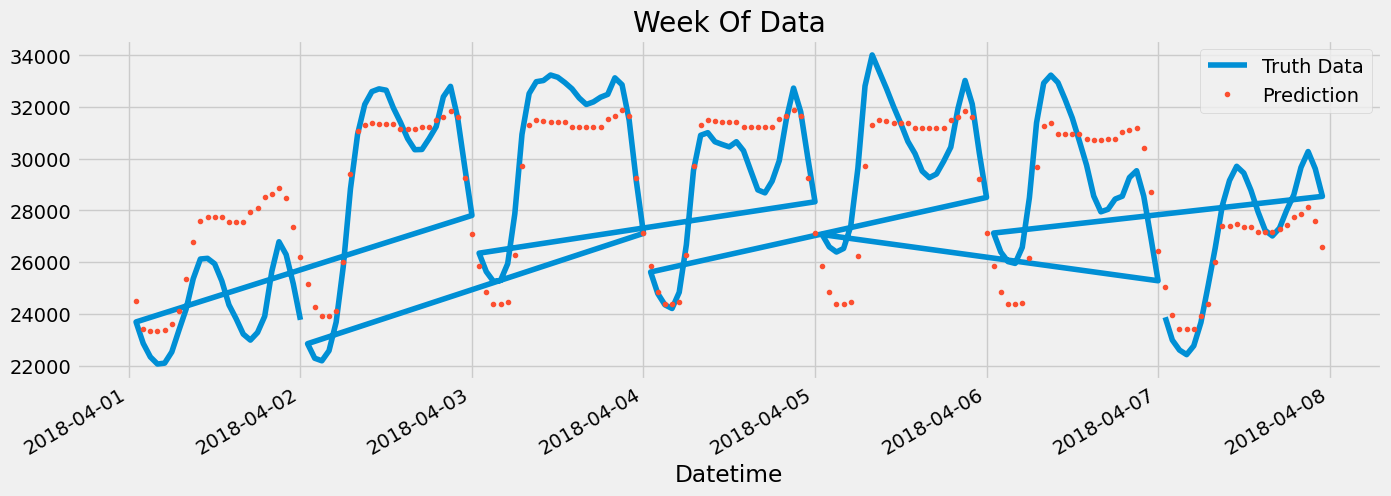

In [23]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
       .plot(figsize=(15, 5), title = 'Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction']\
  .plot(style = '.')

plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [26]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3741.03


## Error

In [28]:
test['error'] = np.abs(test[target] - test['prediction'])
test['date'] = test.index.date

In [30]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

In [31]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64